# Extracting Q–V Curve from Raw Full-Cell Formation Data

This notebook extracts, cleans, and prepares the **Q–V curve (Capacity vs. Voltage)** from raw full-cell formation data (`Nova_Formation-216.csv`), part of the *Cui et al. (2024)* dataset. The processed data is used to perform initial **differential voltage analysis (`dV/dQ`)**, and serves as the foundation for later automation scripts.

---

**Key Operations**
- **Load raw CSV** with non-standard headers (`skiprows=57`)
- **Filter charging segment** (`Current > 0`)
- **Clean data**: remove NaNs and zero/negative capacity values
- **Interpolate** capacity onto a uniform grid (e.g. 300 points)
- **Smooth voltage curve** using Savitzky–Golay filter (`scipy.signal.savgol_filter`)
- **Compute `dV/dQ`** using `np.gradient`:
  - First plotted against **Capacity (Ah)** as `dV/dQ vs Q`
  - Then switched to more common form: **`dV/dQ vs Voltage`**, as advised

---

## Step 1: Pre-processing raw data
Pre-processing ensures dV/dQ analysis is accurate, meaningful, and comparable. Raw battery data includes many steps (charge, discharge, rest), noise, and missing values, which can distort results.

We pre-process by:
- Isolating one clean charge step (e.g., latest full CC-CV charge)
- Dropping missing or zero-capacity rows
- Selecting only relevant columns (Voltage, Capacity, Current)

This produces a smooth, monotonic voltage-capacity curve—essential for valid dV/dQ derivatives and meaningful interpretation of degradation patterns.

In [123]:
#import data
import pandas as pd
file_path = r"D:\FUSE 2025 SUM\battery-analysis-project\Data\data_03032025_cui2024_formation_analysis\data_03032025\Formation\Nova_Formation-216.csv"
df = pd.read_csv(file_path, skiprows=57) #turn CSV into DataFrame, treat the 58th row as headers
df.head() #show the first 5 rows of df

,Date and Time,Cycle Number,Step Type,Run Time (h),Step Time (h),Current (A),Potential (V),Capacity (Ah),Temperature (°C),Circuit Temperature (°C),Energy (Wh),dVdt (V/h),dIdt (A/h),Step Number,Step position,Power(W)
0,11/8/2022 1:18:07 PM,1,0,0.000000,0.000000,0.0,1.380930,0.0,33.565968,27.576,0.0,0.0,0.0,1,1,0.0
1,11/8/2022 1:18:08 PM,1,0,0.000308,0.000308,0.0,1.380656,0.0,33.605972,27.582,0.0,0.0,0.0,1,0,0.0
2,11/8/2022 1:18:09 PM,1,0,0.000597,0.000597,0.0,1.380417,0.0,33.644344,27.580,0.0,0.0,0.0,1,0,0.0
3,11/8/2022 1:18:10 PM,1,0,0.000886,0.000886,0.0,1.380176,0.0,33.672253,27.574,0.0,0.0,0.0,1,0,0.0
4,11/8/2022 1:18:11 PM,1,0,0.001175,0.001175,0.0,1.379934,0.0,33.711952,27.571,0.0,0.0,0.0,1,0,0.0


Check the voltage range:
- NE: typically 0–1 V.
- PE: typically 3–4.5 V.
- Full cell: 3–4.2 V (with SOC spanning 0–100%).

In [124]:
print(df['Potential (V)'].max())
print(df['Potential (V)'].min())

4.40003674
1.34913895


**Note**: The upper range 

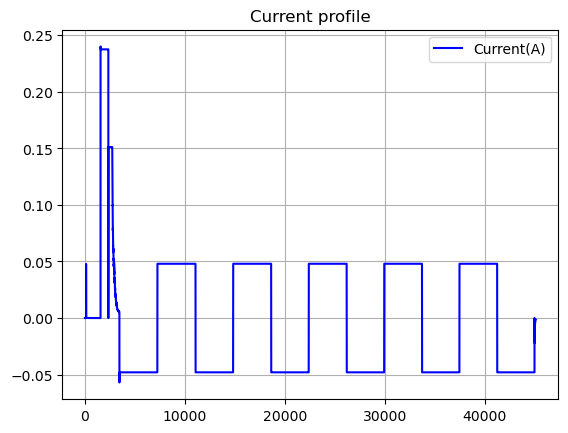

In [125]:
# Plot current-time to identify charge/discharge
import matplotlib.pyplot as plt
plt.plot(df['Current (A)'], label='Current(A)', color='blue')
plt.title("Current profile")
plt.legend()
plt.grid()
plt.show()

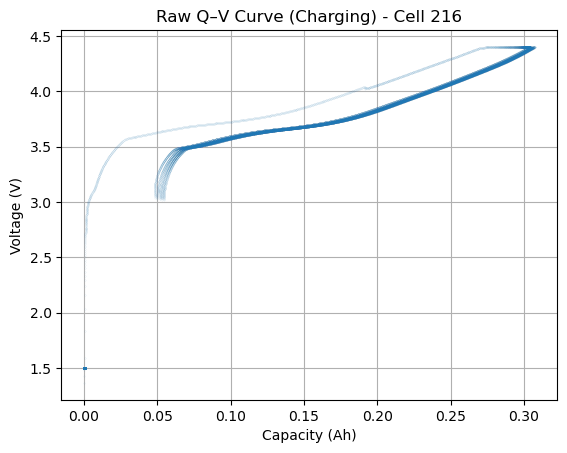

In [126]:
# Filter a clean segment. Charging is chosen here to start with.
charge_df = df[df['Current (A)'] > 0].copy()

# Leave only columns 'Voltage' and 'Capacity'
# Get rid of NaN (missing rows)
# Reset index, and drop the column of original index
charge_df = charge_df[['Potential (V)', 'Capacity (Ah)']].dropna().reset_index(drop=True)

# Filter out the rows with capacity > 0
charge_df = charge_df[charge_df['Capacity (Ah)'] > 0].reset_index(drop=True)

# Visualise
plt.plot(charge_df['Capacity (Ah)'], charge_df['Potential (V)'], marker='.', markersize=0.07, linestyle='None')
plt.xlabel("Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.title("Raw Q–V Curve (Charging) - Cell 216")
plt.grid(True)
plt.show()

**Note:** The raw Q–V curve for Cell 216 begins around 1.35 V. This is expected, as the cell is likely undergoing its first charge from an uncharged state — a condition common in lab-prepared or half-cell datasets. In contrast, commercial cells often arrive partially charged (~50–60% SoC) and may not show such low voltage regions. This initial formation cycle is important to include in diagnostics but may behave differently from regular cycling.

### Isolate 1 charging segment

From df.head() above we know there are columns '**Step** Type/Time/Number/Position'. (For more explanation, see `battery-terminology.md`)


In [127]:
# Preview all Step types (different operations)
print(df['Step Type'].unique())

# Check which Step Type means charging (analysis see below)
df.groupby('Step Type')['Current (A)'].describe()

[ 0  7  8  1  2  9 10]


,count,mean,std,min,25%,50%,75%,max
Step Type,,,,,,,,
0,118.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,19754.0,0.055464,0.036934,0.000000,0.047994,0.047994,0.047994,0.240120
2,22533.0,-0.047984,0.000788,-0.056970,-0.047997,-0.047997,-0.047997,0.000000
7,397.0,0.149215,0.015953,0.000000,0.151188,0.151188,0.151189,0.151189
8,2156.0,0.009974,0.022359,0.000013,0.000021,0.000036,0.007258,0.146288
9,4.0,-0.034844,0.023330,-0.047997,-0.047990,-0.045689,-0.032543,0.000000
10,126.0,-0.006361,0.007126,-0.040339,-0.007111,-0.003977,-0.002279,-0.001401


To analyze battery protocols, we first need to determine what each numeric `Step Type` actually represents (e.g., charge, discharge, rest). These codes are dataset-specific, so we infer their meaning from the data itself.

We use the following reasoning:

| Logic                        | Evidence in the Data Table above              |
|-------------------------------|-------------------------------------------------|
| Charging → positive current    | `Step Type = 1`, `7`, `8` (mean current > 0)    |
| Discharging → negative current | `Step Type = 2`, `9`, `10` (mean current < 0)   |
| Rest → near-zero current       | `Step Type = 0` (mean current ≈ 0)              |
| Core steps = long periods      | `Step Type = 1`, `2`, `8` (thousands of rows)   |
| Transient steps = brief events | `Step Type = 9`, `10` (only a few rows recorded) |

**Conclusion (for this dataset)**:

- `Step Type 1` → Constant-current charge  
- `Step Type 2` → Constant-current discharge  
- `Step Type 8` → Constant-voltage hold (very low current)  
- `Step Type 0` → Likely rest or initialization  
- `Step Type 7` → Possibly fast-charge or protocol variation  
- `Step Type 9`, `10` → Transient events (e.g. noise, end steps)

So now we know Step Type == 1 means **CC charge**

In [128]:
# Inspect `Step Number` used during charging
df[df['Step Type'] == 1]['Step Number'].value_counts()

Step Number
7     3816
10    3805
13    3794
16    3784
19    3774
3      781
Name: count, dtype: int64

In [129]:
# Pick a good Step Number (7 chosen here, as it contains max data points, and may correspond to charging in the first/one of the first cycles - more standard)
charge_df = df[(df['Step Type'] == 1) & (df['Step Number'] == 7)].copy()

# Leave only the columns we care
charge_df = charge_df[['Potential (V)', 'Capacity (Ah)', 'Current (A)']].dropna()

# Leave only valid data (after things become stable)
charge_df = charge_df[charge_df['Capacity (Ah)'] > 0]

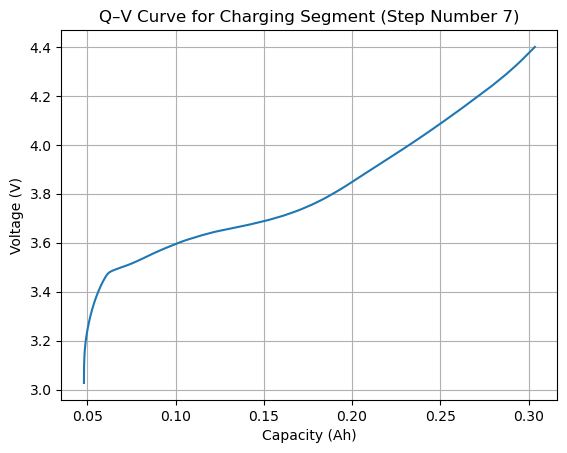

In [130]:
# Visualise
plt.plot(charge_df['Capacity (Ah)'], charge_df['Potential (V)'])
plt.title("Q–V Curve for Charging Segment (Step Number 7)")
plt.xlabel("Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.show()

### Store processed data for Step 2

In [131]:
# Store as processed data for next step (without storing index as an extra column)
charge_df.to_csv('../Data/processed_data/qv_cell216_charge.csv', index=False)

## Step 2: Interpolate & Calculate dV/dQ
To analyze battery degradation, we often compute `dV/dQ` from voltage–capacity (`V–Q`) data. However, **numerical differentiation amplifies measurement noise**, leading to unstable or misleading `dV/dQ` curves.

To smooth out noise while preserving critical features like peaks, we apply **Savitzky-Golay filtering** using `scipy.signal.savgol_filter`. This method performs a local polynomial fit over a moving window to smooth the data or its derivative.

However, **`savgol_filter` requires that the input x-axis (`Q`) be uniformly spaced**. Since raw capacity values are typically **irregularly spaced**, we first apply **interpolation** (e.g., via `scipy.interpolate.interp1d`) to generate a new, **uniformly spaced capacity axis**.

This preprocessing step ensures that:
- Derivatives are computed consistently,
- The smoothing is valid,
- Peaks in `dV/dQ` are physically meaningful.

### Interpolation

In [132]:
import numpy as np
from scipy.signal import savgol_filter

# Extract values from the pre-processed data
Q_raw = charge_df['Capacity (Ah)'].values
V_raw = charge_df['Potential (V)'].values

# Create the uniform Q grid
Q_interp = np.linspace(Q_raw.min(), Q_raw.max(), 1000)
# Interpolate to get corresponding V values
V_interp = np.interp(Q_interp, Q_raw, V_raw)

### Calculate dV/dQ

In [133]:
dVdQ = np.gradient(V_interp, Q_interp)

### Smoothing

In [134]:
dVdQ_smooth = savgol_filter(dVdQ, window_length=10, polyorder=3)

The two parameters (**windown length** and the **order of polynomial fit**) were adjusted to ensure proper smoothing.   
However, this was not investigated in detail due to time constraints within the scope of this project.

### Plot

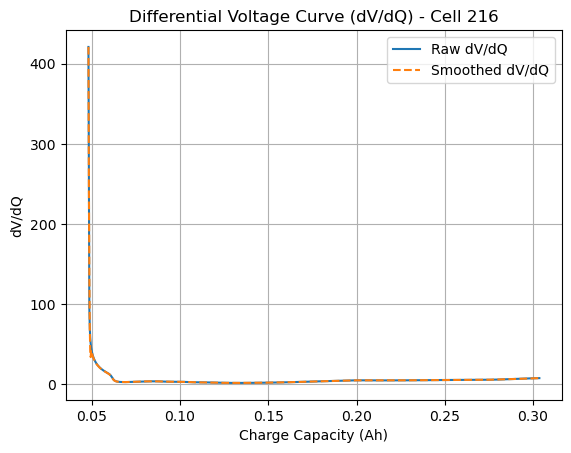

In [135]:
# Plots against capcity
plt.figure()
plt.plot(Q_interp, dVdQ, label='Raw dV/dQ')
plt.plot(Q_interp, dVdQ_smooth, label='Smoothed dV/dQ', linestyle='--')
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('dV/dQ')
plt.title("Differential Voltage Curve (dV/dQ) - Cell 216")
plt.legend()
plt.grid()
plt.show()

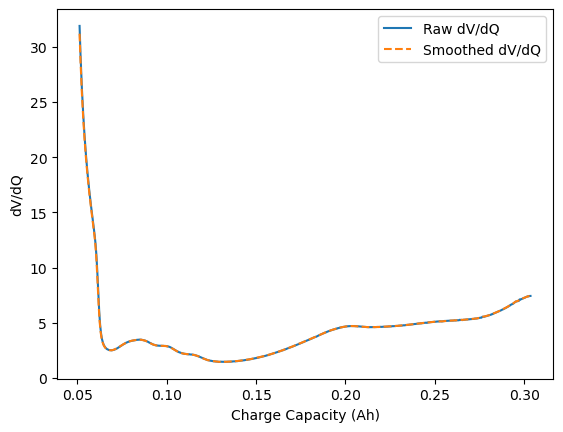

In [136]:
# Deal with the large spike near 0.04 Ah
mask = Q_interp > 0.051 # Create a mask that only contains data points with Q_interp > a certain value
plt.plot(Q_interp[mask], dVdQ[mask], label='Raw dV/dQ')
plt.plot(Q_interp[mask], dVdQ_smooth[mask], '--', label='Smoothed dV/dQ')
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('dV/dQ')
plt.legend()

Text(0, 0.5, 'dV/dQ')

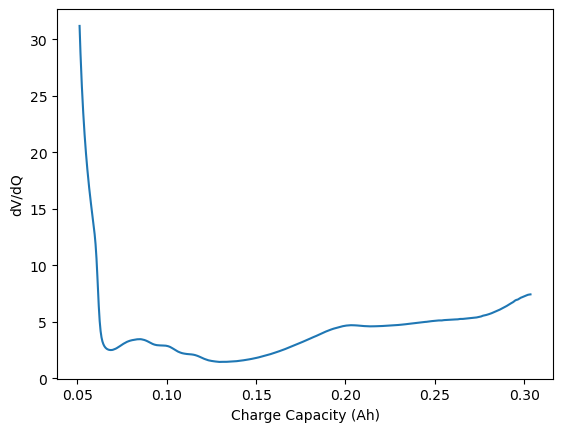

In [137]:
# Isolate smoothed dV/dQ
plt.plot(Q_interp[mask], dVdQ_smooth[mask], label='Smoothed dV/dQ')
plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('dV/dQ')

## Step 3: Peak Detection + Annotated Plot

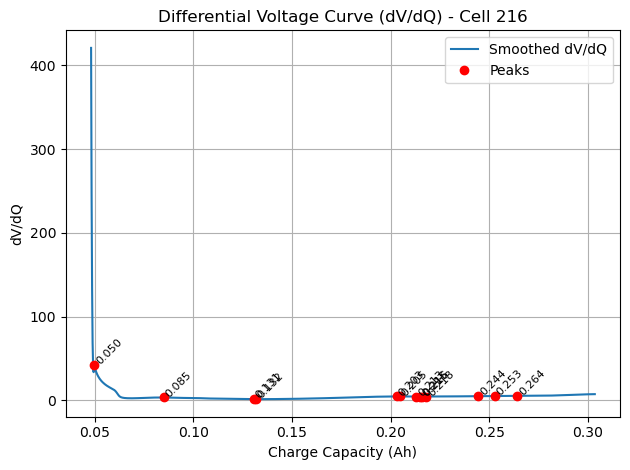

In [138]:
from scipy.signal import find_peaks

# Step 1: Detect peaks
peaks, _ = find_peaks(dVdQ_smooth, height=0.5)  # adjust height as needed

# Step 2: Plot and annotate
plt.figure()
plt.plot(Q_interp, dVdQ_smooth, label='Smoothed dV/dQ')

# Mark peaks
plt.plot(Q_interp[peaks], dVdQ_smooth[peaks], 'ro', label='Peaks')
for i, peak in enumerate(peaks):
    q_val = Q_interp[peak]
    dv_val = dVdQ_smooth[peak]
    plt.text(q_val, dv_val + 0.5, f"{q_val:.3f}", fontsize=8, rotation=45)

plt.xlabel('Charge Capacity (Ah)')
plt.ylabel('dV/dQ')
plt.title('Differential Voltage Curve (dV/dQ) - Cell 216')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('../Plots/dvdq_cell216_step-no7.png', dpi=300)
plt.show()

## Plots agains Voltage (Supervisor-Advised)
### Why dV/dQ is plotted against Voltage (V)

In differential voltage analysis, it is more standard to plot **dV/dQ vs Voltage (V)** rather than against capacity (Q). This is because:

- **Voltage is directly measured**, whereas **capacity is derived** by integrating current over time. This makes Q subject to accumulated error and dependent on how integration is started and stopped.
- As a result, **Q is arbitrary up to a horizontal shift**, especially when aligning cycles across degradation. Peaks may appear to shift in Q even if the underlying electrochemical process has not changed.
- In contrast, **voltage reflects the actual thermodynamic and kinetic behavior** of the electrodes. Phase transitions, lithium intercalation/deintercalation, and SEI formation all occur at specific voltage ranges, not fixed capacity points.
- Therefore, plotting **dV/dQ vs V** allows for more meaningful physical interpretation and **consistent comparison across cycles and cells**, especially during degradation analysis.


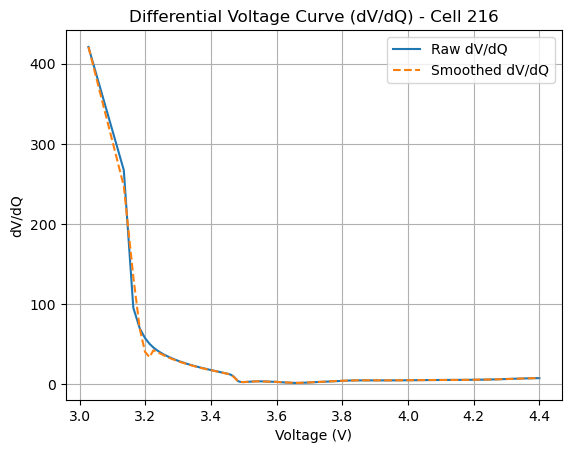

In [139]:
plt.plot(V_interp, dVdQ, label='Raw dV/dQ')
plt.plot(V_interp, dVdQ_smooth, label='Smoothed dV/dQ', linestyle='--')
plt.xlabel('Voltage (V)')
plt.ylabel('dV/dQ')
plt.title("Differential Voltage Curve (dV/dQ) - Cell 216")
plt.legend()
plt.grid()
plt.show()

### Peak Detection + Annotated Plot

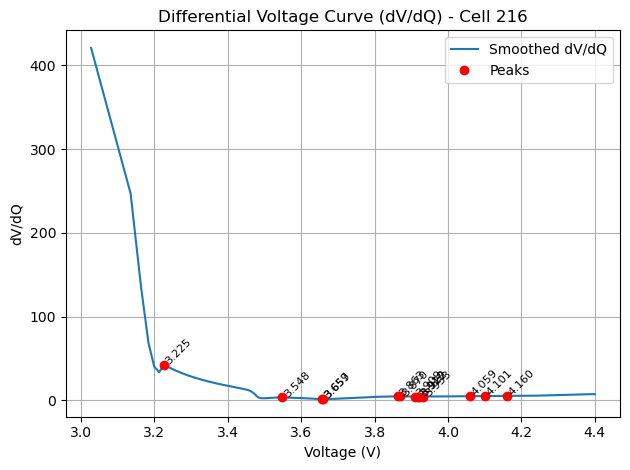

In [140]:
# Step 1: Detect peaks
peaks, _ = find_peaks(dVdQ_smooth, height=0.5)  # adjust height as needed

# Step 2: Plot and annotate
plt.figure()
plt.plot(V_interp, dVdQ_smooth, label='Smoothed dV/dQ')

# Mark peaks
plt.plot(V_interp[peaks], dVdQ_smooth[peaks], 'ro', label='Peaks')
for i, peak in enumerate(peaks):
    V_val = V_interp[peak]
    dv_val = dVdQ_smooth[peak]
    plt.text(V_val, dv_val + 0.5, f"{V_val:.3f}", fontsize=8, rotation=45)

plt.xlabel('Voltage (V)')
plt.ylabel('dV/dQ')
plt.title('Differential Voltage Curve (dV/dQ) - Cell 216')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('../Plots/dvdq_cell216_step-no7.png', dpi=300)
plt.show()